In [1]:
import os
import json

import torch

from rnn_model import LSTMNet, GRUNet
from utils import DotDict, Logger, rmse, rmse_tensor, boolean_string, get_dir, get_time, next_dir, model_dir, get_model
from get_data import dataset_factory, get_data_set

import matplotlib.pyplot as plt
%matplotlib inline
from result import *

## Data

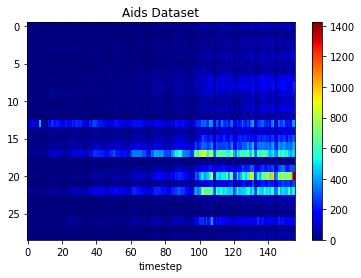

In [2]:
datadir = 'data'
dataset = 'aids'
_, data = get_data_set(datadir, dataset)

plt.figure('Aids Dataset')
plt.imshow(data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('Aids Dataset')
plt.xlabel('timestep')
plt.colorbar()

## Mode List

In [3]:
folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'aids_LSTM'))

In [4]:
lstm = Printer(folder)

In [5]:
print("Model List : ")
lstm.models()

Model List : 


['test_21-56-21-11-52', 'test_23-25-21-11-33']

In [6]:
lstm.get_df(mean=True, min=True)

,test_loss,train_loss,nhid,nlayers
test_21-56-21-11-52,138.517273,355.966705,50.0,3.0
test_23-25-21-11-33,127.515587,300.313354,50.0,3.0
mean,133.016430,328.140030,50.0,3.0
min,127.515587,300.313354,50.0,3.0


In [7]:
lstm.min_idx()

the df is :
                      test_loss  train_loss  nhid  nlayers
test_21-56-21-11-52  138.517273  355.966705    50        3
test_23-25-21-11-33  127.515587  300.313354    50        3


'test_23-25-21-11-33'

## Exp 

In [8]:
exp_name = 'test_23-25-21-11-33'

In [9]:
exp = Exp(exp_name, folder)

D:\Jupyter_Documents\ML-code\research_code\output\aids_LSTM
test_23-25-21-11-33


In [10]:
exp.get_model()

LSTMNet(
  (rnn): LSTM(29, 50, num_layers=3, batch_first=True)
  (linear): Linear(in_features=50, out_features=29, bias=False)
  (out): Linear(in_features=5, out_features=1, bias=False)
)

In [12]:
pred = exp.pred()

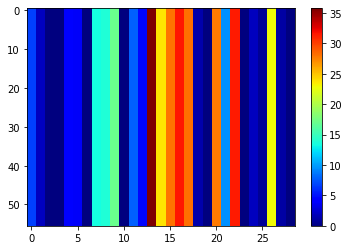

In [14]:
plt.imshow(pred, aspect='auto', cmap='jet')
plt.colorbar()

## Aids LSTM

In [8]:
folder_name = 'aids_LSTM'
model_name = get_model(folder_name)[1]
model_list = model_dir[folder_name]

### The Best Model 

In [ ]:
for model in model_list:
    model = LSTMNet()

In [5]:
outputdir = 'output'
exps = ['stnn']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_input, train_output), (test_input, test_data)  = dataset_factory(datadir, dataset, 700, 5)
    model = rnn(29, config['nhid'], config['nlayers'], 29, config['seq_length'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

## Results

In [6]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction = model.generate(test_input, 396)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
        print(prediction.size())
    print('RMSE {}:\t'.format(exp), mse)

torch.Size([396, 29, 1])
RMSE stnn:	 9.350045204162598


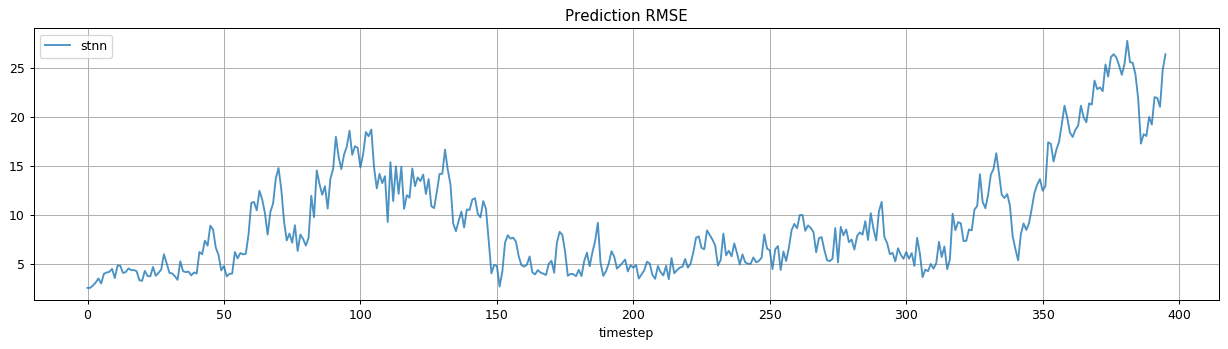

In [7]:
plt.figure('Test plots', figsize=(17, 4), dpi=90)
for exp in exps:
    with open(os.path.join(outputdir, exp, 'logs.json'), 'r') as f:
        logs = json.load(f)

    plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(396)], label=exp, alpha=0.8)

plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

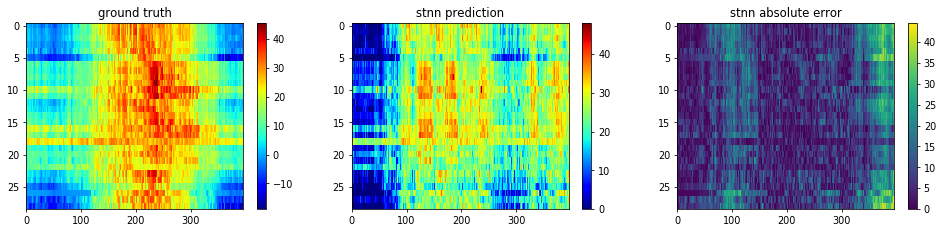

In [8]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))